In [1]:
#imporing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import re

In [2]:
#Loading the dataset
df=pd.read_excel("Online Retail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
# Statistical summary of the dataset
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [5]:
#Checking for missing values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
df["CustomerID"].value_counts()

CustomerID
17841.0    7983
14911.0    5903
14096.0    5128
12748.0    4642
14606.0    2782
           ... 
15070.0       1
15753.0       1
17065.0       1
16881.0       1
16995.0       1
Name: count, Length: 4372, dtype: int64

In [7]:
df[df['CustomerID'].isnull()].head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom


In [8]:
df[df["Quantity"]<0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


In [9]:
df[df["UnitPrice"]<0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


In [10]:
df["InvoiceNo"].dtype

dtype('O')

In [11]:
#df[df["InvoiceNo"].str.match("\D",na=False)].head()
df[df["InvoiceNo"].str.match("^\\d{6}$") == False]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


In [12]:
df[df["StockCode"].str.match("^\d{5}$") == False]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
45,536370,POST,POSTAGE,3,2010-12-01 08:45:00,18.00,12583.0,France
...,...,...,...,...,...,...,...,...
541778,581578,84997C,CHILDRENS CUTLERY POLKADOT BLUE,8,2011-12-09 12:16:00,4.15,12713.0,Germany
541809,581579,85099C,JUMBO BAG BAROQUE BLACK WHITE,10,2011-12-09 12:19:00,1.79,17581.0,United Kingdom
541838,581580,84993A,75 GREEN PETIT FOUR CASES,2,2011-12-09 12:20:00,0.42,12748.0,United Kingdom
541844,581580,85049A,TRADITIONAL CHRISTMAS RIBBONS,1,2011-12-09 12:20:00,1.25,12748.0,United Kingdom


In [13]:
df[df["StockCode"].str.match("^.$", na=False) | df["StockCode"].str.match("^.{4}$", na=False)]['StockCode'].value_counts()

StockCode
POST    1256
M        571
D         77
S         63
CRUK      16
PADS       4
B          3
m          1
Name: count, dtype: int64

In [14]:
df.shape

(541909, 8)

In [16]:
df['InvoiceNo']=df['InvoiceNo'].astype(str)

In [17]:
df["InvoiceNo"] = df["InvoiceNo"].apply(lambda x: re.sub(r"\D", "", x)) 
df1 = df[df["InvoiceNo"].str.match(r"^\d{6}$", na=False)]

In [18]:
df1.shape

(541909, 8)

In [19]:
df1[df1["StockCode"].str.match("^\d{5}$") == False]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
45,536370,POST,POSTAGE,3,2010-12-01 08:45:00,18.00,12583.0,France
...,...,...,...,...,...,...,...,...
541778,581578,84997C,CHILDRENS CUTLERY POLKADOT BLUE,8,2011-12-09 12:16:00,4.15,12713.0,Germany
541809,581579,85099C,JUMBO BAG BAROQUE BLACK WHITE,10,2011-12-09 12:19:00,1.79,17581.0,United Kingdom
541838,581580,84993A,75 GREEN PETIT FOUR CASES,2,2011-12-09 12:20:00,0.42,12748.0,United Kingdom
541844,581580,85049A,TRADITIONAL CHRISTMAS RIBBONS,1,2011-12-09 12:20:00,1.25,12748.0,United Kingdom


In [20]:
df1["StockCode"]=df1["StockCode"].astype(str)
df1['StockCode']=df1['StockCode'].apply(lambda x: re.sub(r"\D",'',x))
df1.shape

(541909, 8)

In [21]:
df2=df1[df1["StockCode"].str.match("^\d{5}$") == True]

In [22]:
df2.shape

(538914, 8)

In [23]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 538914 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    538914 non-null  object        
 1   StockCode    538914 non-null  object        
 2   Description  537475 non-null  object        
 3   Quantity     538914 non-null  int64         
 4   InvoiceDate  538914 non-null  datetime64[ns]
 5   UnitPrice    538914 non-null  float64       
 6   CustomerID   404909 non-null  float64       
 7   Country      538914 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 37.0+ MB


In [24]:
df2.CustomerID.isnull().sum()

134005

In [25]:
df2.dropna(subset=['CustomerID'],inplace=True)

C:\Users\sakib_1584\AppData\Local\Temp\ipykernel_12452\2962422550.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.dropna(subset=['CustomerID'],inplace=True)


In [26]:
df2.shape

(404909, 8)

In [27]:
df2.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [28]:
df2["Description"].value_counts()


Description
WHITE HANGING HEART T-LIGHT HOLDER    2070
REGENCY CAKESTAND 3 TIER              1905
JUMBO BAG RED RETROSPOT               1662
ASSORTED COLOUR BIRD ORNAMENT         1418
PARTY BUNTING                         1416
                                      ... 
FRYING PAN RED POLKADOT                  1
PEG BAG APPLE DESIGN                     1
PINK POLKADOT KIDS BAG                   1
BLACK DIAMOND CLUSTER NECKLACE           1
SET 12 COLOURING PENCILS DOILEY          1
Name: count, Length: 3888, dtype: int64

In [29]:
df2["Description"].unique()

array(['WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE METAL LANTERN',
       'CREAM CUPID HEARTS COAT HANGER', ...,
       'PINK CRYSTAL SKULL PHONE CHARM',
       'CREAM HANGING HEART T-LIGHT HOLDER',
       'PAPER CRAFT , LITTLE BIRDIE'], dtype=object)

In [30]:
df2.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,404909.000000,404909,404909.000000,404909.000000
mean,12.105799,2011-07-10 16:56:48.643670016,2.901129,15295.168304
min,-80995.000000,2010-12-01 08:26:00,0.000000,12346.000000
25%,2.000000,2011-04-06 15:02:00,1.250000,13969.000000
50%,5.000000,2011-07-31 12:02:00,1.950000,15159.000000
75%,12.000000,2011-10-20 13:07:00,3.750000,16794.000000
max,80995.000000,2011-12-09 12:50:00,649.500000,18287.000000
std,249.237543,NaN,4.430846,1710.424057


In [31]:
df2=df2[df2["Quantity"] >= 0]

In [32]:
df2.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,396370.000000,396370,396370.000000,396370.000000
mean,13.046474,2011-07-11 00:04:30.985594624,2.867983,15301.602071
min,1.000000,2010-12-01 08:26:00,0.000000,12346.000000
25%,2.000000,2011-04-07 11:16:00,1.250000,13975.000000
50%,6.000000,2011-07-31 14:39:00,1.950000,15159.000000
75%,12.000000,2011-10-20 14:41:00,3.750000,16803.000000
max,80995.000000,2011-12-09 12:50:00,649.500000,18287.000000
std,180.733597,NaN,4.264566,1709.982593


In [33]:
df_zero=df2[df2["UnitPrice"]==0]
df_zero

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647.0,Germany
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560.0,United Kingdom
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911.0,EIRE
47068,540372,22090,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom
47070,540372,22553,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom
56674,541109,22168,ORGANISER WOOD ANTIQUE WHITE,1,2011-01-13 15:10:00,0.0,15107.0,United Kingdom
86789,543599,84535,FAIRY CAKES NOTEBOOK A6 SIZE,16,2011-02-10 13:08:00,0.0,17560.0,United Kingdom
130188,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,2011-03-23 10:25:00,0.0,13239.0,United Kingdom
139453,548318,22055,MINI CAKE STAND HANGING STRAWBERY,5,2011-03-30 12:45:00,0.0,13113.0,United Kingdom
145208,548871,22162,HEART GARLAND RUSTIC PADDED,2,2011-04-04 14:42:00,0.0,14410.0,United Kingdom


In [34]:
df2.shape

(396370, 8)

In [35]:
df2=df2[df2["UnitPrice"]>0.0]

In [36]:
df2["UnitPrice"].eq(0).sum()

0

In [37]:
df2.shape

(396337, 8)

In [38]:
df2.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,396337.000000,396337,396337.000000,396337.000000
mean,13.012547,2011-07-11 00:04:38.980463616,2.868222,15301.689416
min,1.000000,2010-12-01 08:26:00,0.040000,12346.000000
25%,2.000000,2011-04-07 11:16:00,1.250000,13975.000000
50%,6.000000,2011-07-31 14:39:00,1.950000,15159.000000
75%,12.000000,2011-10-20 14:41:00,3.750000,16803.000000
max,80995.000000,2011-12-09 12:50:00,649.500000,18287.000000
std,179.641245,NaN,4.264663,1709.961948


In [39]:
#Apply now feature engineering
df2['Total Amount']=df2["Quantity"]*df2["UnitPrice"]

In [40]:
df2.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total Amount
0,536365,85123,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom,15.30
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom,25.50
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,11.10
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,11.10
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom,54.08


<Axes: title={'center': 'Monthly Sales Trend'}, xlabel='InvoiceDate'>

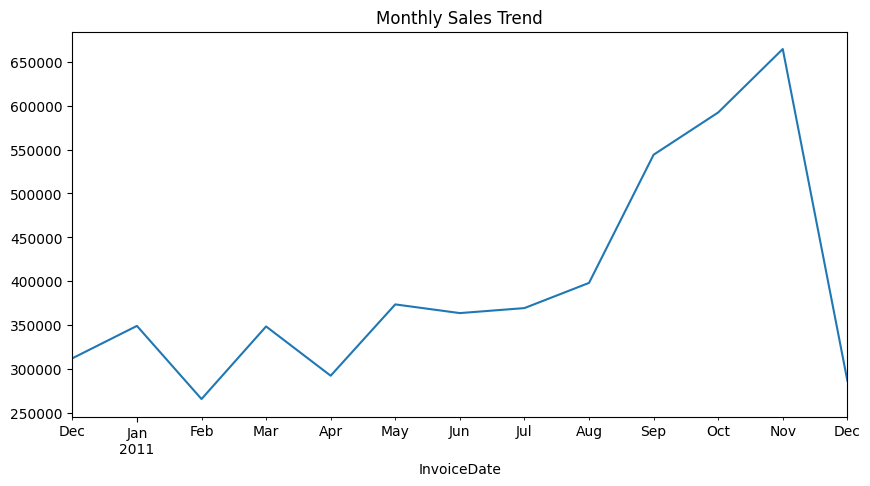

In [41]:
df2["InvoiceDate"] = pd.to_datetime(df2["InvoiceDate"])  # Ensure correct datetime format
df2.set_index("InvoiceDate")["Quantity"].resample("M").sum().plot(kind="line", figsize=(10,5), title="Monthly Sales Trend")


<Axes: title={'center': 'Top 10 Best-Selling Products'}, xlabel='StockCode'>

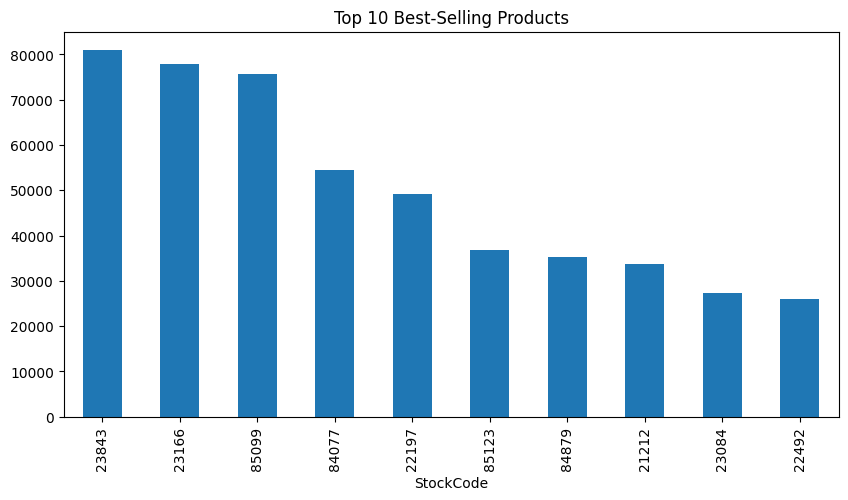

In [42]:
top_products = df2.groupby("StockCode")["Quantity"].sum().nlargest(10)
top_products.plot(kind="bar", figsize=(10,5), title="Top 10 Best-Selling Products")


## Monetary Value, Frequency, and Recency Matter? (RFM Analysis)

In [43]:
latest_purchase=df2["InvoiceDate"].max()

In [44]:
print(latest_purchase)

2011-12-09 12:50:00


In [45]:
df_rfm=df2.groupby("CustomerID").agg({
    "InvoiceDate" : lambda x: (latest_purchase - x.max()).days,
    "InvoiceNo" : "count",
    "Total Amount" : "sum"
   })

In [46]:
df_rfm.rename(columns={"InvoiceDate" : "Recency",
                       "InvoiceNo" : "Frequency",
                       "Total Amount" : "Monetary"
                       }, inplace=True)

In [47]:
df_rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,1,182,4310.00
12348.0,74,27,1437.24
12349.0,18,72,1457.55
12350.0,309,16,294.40


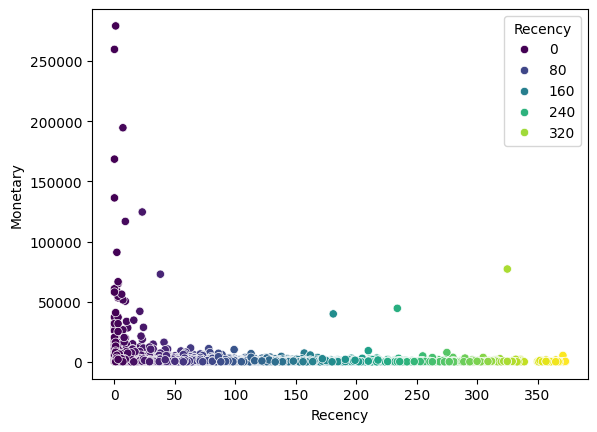

In [48]:
import seaborn as sns
sns.scatterplot(x="Recency", y="Monetary", data=df_rfm, hue="Recency", palette="viridis")
plt.show()



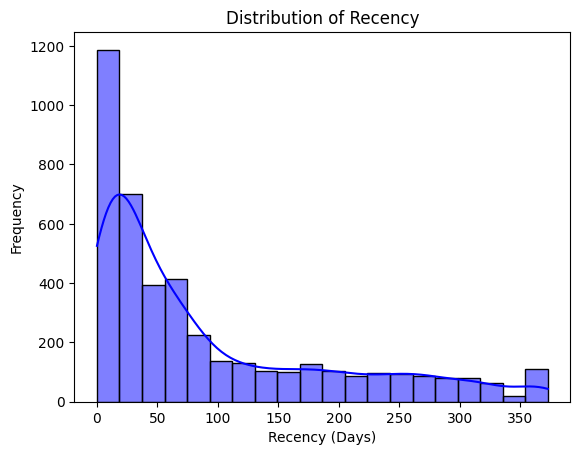

In [49]:
sns.histplot(df_rfm['Recency'], kde=True, color='blue', bins=20)  # kde=True adds a Kernel Density Estimate curve
plt.title('Distribution of Recency')
plt.xlabel('Recency (Days)')
plt.ylabel('Frequency')
plt.show()

In [50]:
# Apply StandardScaler to scale the data
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
df_rfm_scaled=sc.fit_transform(df_rfm)

In [51]:
df_rfm_scaled=pd.DataFrame(df_rfm_scaled,columns=df_rfm.columns)
df_rfm_scaled.head()

,Recency,Frequency,Monetary
0,2.329115,-0.396755,8.439044
1,-0.905532,0.397209,0.256951
2,-0.176738,-0.282705,-0.065597
3,-0.735813,-0.085311,-0.063316
4,2.169379,-0.330957,-0.193912


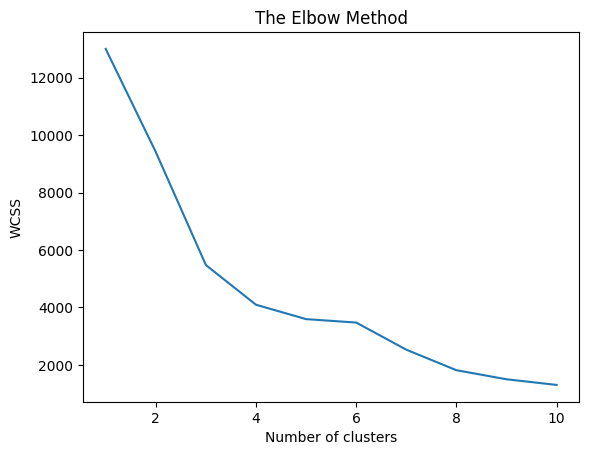

In [52]:
# Elbow Method
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(df_rfm_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [53]:
#Apply KMeans Clustering
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)

df_rfm_scaled["Cluster"]=kmeans.fit_predict(df_rfm_scaled)

df_rfm_scaled

,Recency,Frequency,Monetary,Cluster
0,2.329115,-0.396755,8.439044,2
1,-0.905532,0.397209,0.256951,0
2,-0.176738,-0.282705,-0.065597,0
3,-0.735813,-0.085311,-0.063316,0
4,2.169379,-0.330957,-0.193912,1
...,...,...,...,...
4329,1.849908,-0.357277,-0.206689,1
4330,0.881511,-0.370436,-0.217892,1
4331,-0.845631,-0.348503,-0.206976,0
4332,-0.885565,2.906311,0.007574,0


In [54]:
# Get the centers of each cluster
cluster_centers = kmeans.cluster_centers_
print("Cluster Centers:\n", cluster_centers)

# Get cluster distribution (How many customers in each cluster?)
print(df_rfm_scaled['Cluster'].value_counts())


Cluster Centers:
 [[-5.12995609e-01  4.67711520e-02 -1.16331176e-02]
 [ 1.54271568e+00 -2.78432172e-01 -1.63649565e-01]
 [-6.16011025e-01  3.61411146e+00  1.33029595e+01]
 [-9.05531898e-01  2.49333369e+01  7.15022871e+00]]
Cluster
0    3233
1    1083
2      14
3       4
Name: count, dtype: int64


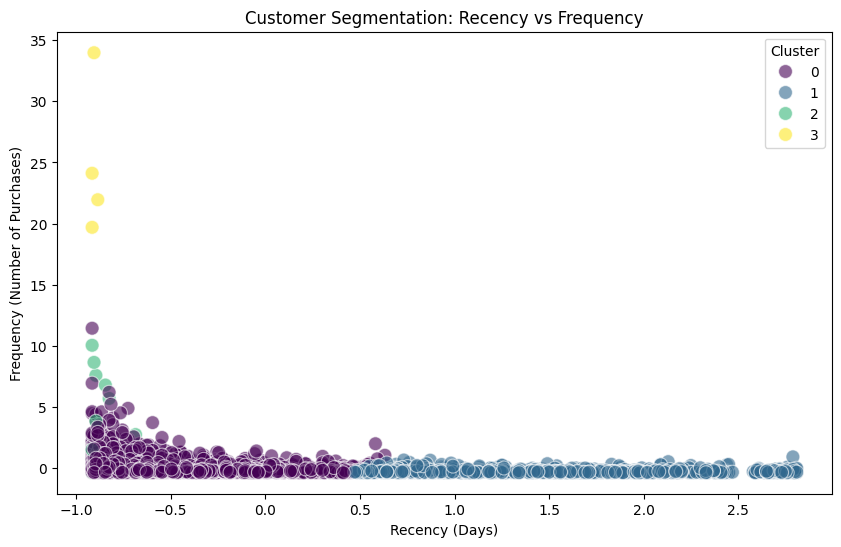

In [55]:

# Plot Recency vs Frequency with color for each cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency', y='Frequency', data=df_rfm_scaled, hue='Cluster', palette='viridis', s=100, alpha=0.6)
plt.title('Customer Segmentation: Recency vs Frequency')
plt.xlabel('Recency (Days)')
plt.ylabel('Frequency (Number of Purchases)')
plt.legend(title="Cluster")
plt.show()


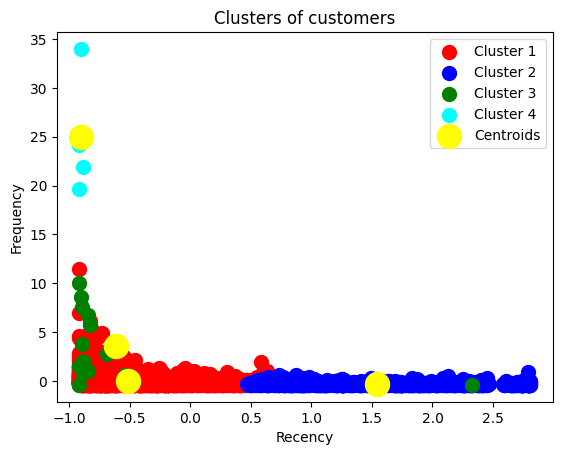

In [56]:

plt.scatter(df_rfm_scaled[df_rfm_scaled["Cluster"] == 0]["Recency"], 
            df_rfm_scaled[df_rfm_scaled["Cluster"] == 0]["Frequency"], 
            s=100, c='red', label='Cluster 1')

plt.scatter(df_rfm_scaled[df_rfm_scaled["Cluster"] == 1]["Recency"], 
            df_rfm_scaled[df_rfm_scaled["Cluster"] == 1]["Frequency"], 
            s=100, c='blue', label='Cluster 2')

plt.scatter(df_rfm_scaled[df_rfm_scaled["Cluster"] == 2]["Recency"], 
            df_rfm_scaled[df_rfm_scaled["Cluster"] == 2]["Frequency"], 
            s=100, c='green', label='Cluster 3')

plt.scatter(df_rfm_scaled[df_rfm_scaled["Cluster"] == 3]["Recency"], 
            df_rfm_scaled[df_rfm_scaled["Cluster"] == 3]["Frequency"], 
            s=100, c='cyan', label='Cluster 4')



plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:, 1], 
            s=300, c='yellow', label='Centroids')

plt.title('Clusters of customers')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend()
plt.show()

